In [1]:
import transit #commit no. 45e97c6, autodiff branch
import batman #commit no. 972164f, master branch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time = np.arange(-2, 2, 0.0001)
texp = 1626./86400

In [3]:
rhostar = 0.5
q1 = 0.5
q2 = 0.5
u1 = 2*math.sqrt(q1)*q2 #convert q1,q2 to u1,u2 from Kipping (2013)
u2 = math.sqrt(q1)*(1.-2*q2)
dilution = 0.2 #i've implemented the dilution calculation into my copy of the transit package
period = 5. #in days
t0 = 0. #epoch in days
b = 0.6
rprs = 0.15
e = 0.
w = 3. #omega in radians
periodcgs = period*86400.
big_G = 6.6726e-8
ars = ((rhostar*big_G*periodcgs**2)/(3*math.pi))**(1./3.) #a over R_star, from Winn (2014), eqn 30
incl = math.acos((b/ars)*((1+e*math.sin(w))/(1-e**2))) *180./math.pi #i from Winn (2014), eqn 7

Setting up the `transit` model

In [4]:
central = transit.Central(q1=q1, q2=q2) #setting the central body of the system
central.density = rhostar
s = transit.System(central, dilution=dilution)

In [5]:
r = central.radius * rprs
body = transit.Body(radius=r, mass=0, period=period, t0=t0, e=e, omega=w, b=b)
s.add_body(body)

In [6]:
transitflux = s.light_curve(time,texp=texp)

Setting up the `batman` model

In [7]:
params = batman.TransitParams()
params.per = period
params.t0 = t0
params.rp = rprs
params.a = ars
params.inc = incl
params.ecc = e
params.w = w
params.limb_dark = 'quadratic'
params.u = [u1,u2]

In [8]:
model = batman.TransitModel(params,time,nthreads=1,supersample_factor=5.,exp_time=texp)
batmanflux = model.light_curve(params)
dilutedbatmanflux = 1-(1-batmanflux)*(1-dilution)

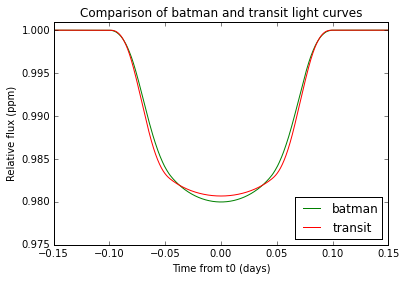

In [10]:
plt.plot(time,dilutedbatmanflux,'g',label='batman')
plt.plot(time,transitflux,'r',label='transit')
plt.xlim(-0.15,0.15)
plt.ylim(0.975,1.001)
plt.legend(loc='lower right')
plt.xlabel('Time from t0 (days)')
plt.ylabel('Relative flux (ppm)')
plt.title('Comparison of batman and transit light curves')
plt.show()

So there is a discrepancy between the two packages, and based on the shape of the light curves it looks like the differences lies in the implementation of limb darkening.